# Co-clustering

## Introduction

This notebook illustrates how to use [Clustering Geo-data Cubes (CGC)](https://cgc.readthedocs.io) to perform a co-clustering analysis of geo-spatial data. 

The use of co-clustering overcomes some of the limitations of traditional one-dimensional clustering techniques (such as k-means). For spatio-temporal data, traditional clustering  allows the identification of spatial patterns across the full time span of the data, or temporal patterns for the whole spatial domain under consideration. With co-clustering, the space and time dimensions are simultaneously clustered. This allows the creation of groups of elements that behave similarly in both dimensions. These groups are called co-clusters and typically represent a region of the study area that has similar temporal dynamics for a subset of the study period. 

In this notebook we illustrate how to perform a co-clustering analysis with the CGC package using a phenological dataset representing the day of the year of first leaf appearance in the conterminous United States. For more information about this dataset please check [here](https://doi.org/10.1016/j.agrformet.2018.06.028). 

Note that in addition to CGC, whose installation instructions can be found [here](https://github.com/phenology/cgc), few other packages are required in order to run this notebook. Please have a look at this tutorial's [installation instructions](https://github.com/escience-academy/tutorial-cgc). 

## The data

The data employed in this tutorial is a low-resolution version of the extended spring-index data set calculated for the conterminous United States (CONUS) from 1980 to 2020. For this tutorial, the resolution of the original dataset (1 km) has been decreased by a factor 25. The data set includes three spring indices representing the day of the year of first leaf appearance, the day of first bloom and the day of last freeze. The data is provided in [Zarr](https://zarr.readthedocs.io/en/stable/) format.

For more information about the data have a look at the original publication https://doi.org/10.1016/j.agrformet.2018.06.028 - please cite this reference if you use the data!

## Imports and general configuration

In [1]:
import cgc
import logging
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from dask.distributed import Client, LocalCluster

from cgc.coclustering import Coclustering
from cgc.kmeans import Kmeans
from cgc.utils import mem_estimate_coclustering_numpy, calculate_cocluster_averages

print(f'CGC version: {cgc.__version__}')

CGC version: 0.4.0


CGC makes use of `logging`, set the desired verbosity via:

In [2]:
logging.basicConfig(level=logging.INFO)

## Reading the data

We use [the Xarray package](http://xarray.pydata.org) to read the data. If you want to know more about this Python package please check [here](http://xarray.pydata.org/en/stable/) and/or watch this introductory [video](https://youtu.be/g0GKqYkp9kk) to get to know Xarray in ±45 mins

We open the Zarr archive containing the data set and select the "first-leaf" spring index:

In [3]:
spring_indices = xr.open_zarr('../data/spring-indices.zarr', chunks=None)
print(spring_indices)

<xarray.Dataset>
Dimensions:      (time: 40, y: 155, x: 312)
Coordinates:
  * time         (time) int64 1980 1981 1982 1983 1984 ... 2016 2017 2018 2019
  * x            (x) float64 -126.2 -126.0 -125.7 -125.5 ... -56.8 -56.57 -56.35
  * y            (y) float64 49.14 48.92 48.69 48.47 ... 15.23 15.01 14.78 14.56
Data variables:
    first-bloom  (time, y, x) float64 ...
    first-leaf   (time, y, x) float64 ...
    last-freeze  (time, y, x) float64 ...
Attributes:
    crs:        +init=epsg:4326
    res:        [0.22457882102988036, -0.22457882102988042]
    transform:  [0.22457882102988036, 0.0, -126.30312894720473, 0.0, -0.22457...


In [4]:
spring_index = spring_indices['first-leaf']
print(spring_index)

<xarray.DataArray 'first-leaf' (time: 40, y: 155, x: 312)>
[1934400 values with dtype=float64]
Coordinates:
  * time     (time) int64 1980 1981 1982 1983 1984 ... 2015 2016 2017 2018 2019
  * x        (x) float64 -126.2 -126.0 -125.7 -125.5 ... -56.8 -56.57 -56.35
  * y        (y) float64 49.14 48.92 48.69 48.47 ... 15.23 15.01 14.78 14.56


The spring index is now loaded as a three-dimensional array (a `DataArray`). The three dimensions of the array (time, x, y) are labeled with coordinates (year, longitude, latitude).

We can inspect the data set by plotting a slice along the time dimension:

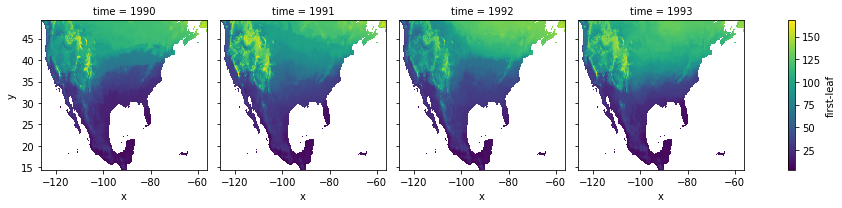

In [5]:
# select years from 1990 to 1993
spring_index.sel(time=slice(1990, 1993)).plot.imshow(col="time")

We manipulate the array spatial dimensions creating a combined (x, y) dimension. We also drop the grid cells that have null values for any of the years:

In [6]:
spring_index = spring_index.stack(space=['x', 'y'])
location = np.arange(spring_index.space.size) # create a combined (x,y) index
spring_index = spring_index.assign_coords(location=('space', location))

# drop pixels that are null-valued for any of the time indices
spring_index = spring_index.dropna('space', how='any')  
print(spring_index)

<xarray.DataArray 'first-leaf' (time: 40, space: 23584)>
array([[ 60.,  63.,  73., ..., 127., 126., 125.],
       [ 35.,  38.,  45., ..., 130., 129., 127.],
       [ 59.,  63.,  74., ..., 135., 136., 136.],
       ...,
       [ 63.,  68.,  77., ..., 137., 139., 137.],
       [ 46.,  51.,  61., ..., 133., 133., 109.],
       [ 63.,  67.,  77., ..., 140., 140., 139.]])
Coordinates:
  * time      (time) int64 1980 1981 1982 1983 1984 ... 2015 2016 2017 2018 2019
  * space     (space) MultiIndex
  - x         (space) float64 -126.2 -126.0 -125.7 ... -56.35 -56.35 -56.35
  - y         (space) float64 49.14 49.14 49.14 48.92 ... 47.57 47.12 46.9 46.67
    location  (space) int64 0 155 310 311 465 ... 48211 48212 48214 48215 48216


In [7]:
# size of the matrix
print("{} MB".format(spring_index.nbytes/2**20))

7.197265625 MB


## Co-clustering

### Overview

Once we have loaded the data set as a 2D array, we can run the co-clustering analysis. Starting from a random co-cluster assignment, the algorithm implemented in CGC iteratively updates the co-clusters until the loss function that corresponds to the information loss in each cluster does not significantly change in two consecutive iterations (a threshold is provided). The solution reached by the algorithm does not necessarily represent the global minimum of the loss function (it might be a local minimum). Thus, multiple differently-initialized runs need to be performed in order to sample the cluster space, and the cluster assignment with the lowest loss-function value selected as best candidate solution. Note that these runs represent embarrassingly parallel tasks, so they can be efficiently executed in parallel. For more information about the algorithm, have a look at CGC's co-clustering [documentation](https://cgc.readthedocs.io/en/latest/user_manual.html#co-clustering).

To run the co-clustering analysis for the first-bloom data set that we have loaded in the previous section, we first have to choose an initial number of spatial and temporal clusters and set the values of few other parameters:

In [8]:
num_time_clusters = 3
num_space_clusters = 20

max_iterations = 50  # maximum number of iterations
conv_threshold = 0.1  # convergence threshold 
nruns = 3  # number of differently-initialized runs

**NOTE**: the number of clusters have been selected in order to keep the memory requirement and the time of the execution suitable to run this tutorial on [mybinder.org](https://mybinder.org). If the infrastructure where you are running this notebook has more memory and computing power available, feel free to increase these values.

We then instantiate a `Coclustering` object:

In [9]:
cc = Coclustering(
    spring_index.data,  # data set (must be a 2D array)
    num_time_clusters,  # number of clusters in the first dimension of the data set (rows)
    num_space_clusters,  # number of clusters in the second dimension of the data set (columns)
    max_iterations=max_iterations,  
    conv_threshold=conv_threshold, 
    nruns=nruns
)

We are now ready to run the analysis. CGC offers multiple implementations of the same co-clustering algorithm, as described in the following subsections. Ultimately, the most suitable implementation for a given problem is determined by the size of the data set of interest and by the infrastructure that is available for the analysis.

### Local (Numpy-based) implementation

A first implementation is based on [Numpy](https://numpy.org) and [threading](https://docs.python.org/3/library/threading.html). It is suitable to run the co-clustering analysis locally, with differently-initialized co-clustering runs being executed in parallel as multiple threads. The `nthreads` argument sets the number of runs that are simultaneously executed: 

In [10]:
results = cc.run_with_threads(nthreads=1)

INFO:cgc.coclustering:Retrieving run 0
INFO:cgc.coclustering:Error = -240876162.66129196
INFO:cgc.coclustering:Retrieving run 1
INFO:cgc.coclustering:Error = -240877171.69312268
INFO:cgc.coclustering:Retrieving run 2
INFO:cgc.coclustering:Error = -240875279.22849774


If a multi-core processor is available, speedup is expected by setting `nthreads` to the number of available cores. Note, however, that the memory requirement also increases for increasing `nthreads`. 

The output might indicate that for some of the runs convergence is not achieved within the specified number of iterations - increasing this value to ~500 should lead to converged solutions within the threshold provided.

Calling the method again will perform a new set of co-clustering runs, improving the sampling of the cluster space:

In [11]:
results = cc.run_with_threads(nthreads=1)

INFO:cgc.coclustering:Retrieving run 3
INFO:cgc.coclustering:Error = -240875108.32362488
INFO:cgc.coclustering:Retrieving run 4
INFO:cgc.coclustering:Error = -240875185.3371955
INFO:cgc.coclustering:Retrieving run 5
INFO:cgc.coclustering:Error = -240875341.17002285


### Reducing the memory footprint

The implementation illustrated in the previous section internally exploits vectorized operations between work arrays, whose size increases with both the data set size and the number of row and column clusters. If the data set is relatively large, the memory requirement becomes a bottle neck in the choice of the number of clusters in the analysis. 

One can estimate the peak memory of a single co-clustering run with the following utility function: 

In [12]:
n_rows, n_cols = spring_index.shape
mem_estimate_coclustering_numpy(
    n_rows=n_rows, 
    n_cols=n_cols,
    nclusters_row=num_time_clusters,
    nclusters_col=num_space_clusters,
)

INFO:cgc.utils:Estimated memory usage: 14.85MB, peak number: 2


(14.850578308105469, 'MB', 2)

The estimated peak memory required for the execution of the co-clustering analysis of a data set that is few GB large with 10-1000 clusters in each dimension can easily exceed 50 GB. If this amount of memory is not available on a single machine, CGC offers two alternatives. On the one hand, one can make use of a different implementation that significantly reduces the memory footprint of the algorithm, activated via the `low_memory` argument:

In [13]:
results = cc.run_with_threads(nthreads=1, low_memory=True)

INFO:cgc.coclustering:Retrieving run 6
INFO:cgc.coclustering:Error = -240876958.05651614
INFO:cgc.coclustering:Retrieving run 7
INFO:cgc.coclustering:Error = -240876149.1258034
INFO:cgc.coclustering:Retrieving run 8
INFO:cgc.coclustering:Error = -240876966.70085263


Check out the [memory_profiler](https://github.com/pythonprofilers/memory_profiler) package, in particular the IPython `%memit` magic that this package implements, to compare the difference in memory usage for the two implementations (install with: `pip install memory_profiler`, load the magic in the notebook with: `%load_ext memory_profiler`). Look at the "increment" field, but note that the difference between the two implementations becomes significant only for large datasets and/or number of clusters (it is difficult to appreciate it with the default data set/parameters of this notebook).

The reduced memory requirement comes at the cost of performance, since some of the vectorized operations are replaced with (slower) for loops. The performance loss of this low-memory algorithm can be significantly mitigated by activating [Numba](https://numba.pydata.org)’s just-in-time (JIT) compilation for these loops' vectorization, which is employed in CGC when setting the optional argument `numba_jit=True`. Note that the larger the number of clusters, the larger the speedup obtained with Numba JIT compilation.

An alternative approach to tackle co-clustering analyses that do not fit the memory of a single machine, is to run them on a cluster of compute nodes. This type of analyses can be carried out with the Dask-based co-clustering implementation that is described in the following section.

### Co-clustering with Dask

CGC also includes a co-clustering implementation that makes use of [Dask](https://dask.org) and it is thus suitable to run the algorithm on distributed systems (e.g. on a cluster of compute nodes). In the implementation illustrated here, Dask arrays are employed to process the data in chunks that are distributed across the nodes of a compute cluster.

Dask arrays can be employed as the underlying data structure in a `DataArray`. Specifying the `chunks` argument when loading a data set with Xarray (e.g. in `xr.open_zarr()`), allows one to load the data in chunks and to distribute these across the nodes of the cluster. This is especially relevant for data sets that do not fit the memory of a single node of the cluster!

In [14]:
# set a chunk size of 10 along the time dimension, no chunking in x and y
chunks = {'time': 10, 'x': -1, 'y': -1 }
spring_indices = xr.open_zarr('../data/spring-indices.zarr', chunks=chunks)
spring_index_dask = spring_indices['first-leaf']
print(spring_index_dask)

<xarray.DataArray 'first-leaf' (time: 40, y: 155, x: 312)>
dask.array<open_dataset-fa144aee32b839aa7ba4d6f9bf20e0a8first-leaf, shape=(40, 155, 312), dtype=float64, chunksize=(10, 155, 312), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 1980 1981 1982 1983 1984 ... 2015 2016 2017 2018 2019
  * x        (x) float64 -126.2 -126.0 -125.7 -125.5 ... -56.8 -56.57 -56.35
  * y        (y) float64 49.14 48.92 48.69 48.47 ... 15.23 15.01 14.78 14.56


We perform the same data manipulation as carried out in the previuos section. Note that all operations involving Dask arrays (including the data loading) are computed ["lazily"](https://tutorial.dask.org/01x_lazy.html) (i.e. they are not carried out until the very end).

In [15]:
spring_index_dask = spring_index_dask.stack(space=['x', 'y'])
spring_index_dask = spring_index_dask.dropna('space', how='any')

In [16]:
cc_dask = Coclustering(
    spring_index_dask.data,
    num_time_clusters,
    num_space_clusters,  
    max_iterations=max_iterations,  
    conv_threshold=conv_threshold, 
    nruns=nruns
)

One could use Dask to distribute data and computation across a cluster of virtual machines in a cloud infrastructure or on a set of compute nodes in a HPC system. Here, we make instead use of a local Dask cluster, i.e. a cluster of processes and threads running on the same machine where the cluster is created:

In [17]:
cluster = LocalCluster()
print(cluster)

LocalCluster(8569e97c, 'tcp://127.0.0.1:60004', workers=4, threads=8, memory=16.00 GiB)


Connection to the cluster takes place via the `Client` object:

In [18]:
client = Client(cluster)
print(client)

<Client: 'tcp://127.0.0.1:60004' processes=4 threads=8, memory=16.00 GiB>


Note that the same framework can be employed to connect to a different type of cluster (use the cluster's scheduler address as argument for `Client`). Further information on how to setup a Dask cluster can be found in the [Dask documentation](https://docs.dask.org/en/latest/setup.html). 

To start the co-clustering runs, we now pass the instance of the `Client` to the `run_with_dask` method:

In [19]:
results = cc_dask.run_with_dask(client=client)

INFO:cgc.coclustering:Run 0
INFO:cgc.coclustering:Error = -240876241.2667739
INFO:cgc.coclustering:Run 1
INFO:cgc.coclustering:Error = -240876890.42587203
INFO:cgc.coclustering:Run 2
INFO:cgc.coclustering:Error = -240877823.56913155


Note that `run_with_dask`, like `run_with_threads`, also accepts a `low_memory` argument. In the Numpy-based implementation, the `low_memory` argument switches between co-clustering algorithms with different memory footprints. In the Dask-based implementation, `low_memory=False` submits instead differently-initialized runs as parallel tasks to the Dask cluster, typically leading to very large memory usages. This feature is experimental and should generally be avoided.  

When the runs are finished, we can close the connection to the cluster:

In [20]:
client.close()

### Inspecting the results 

The objects returned by the `run_with_threads` and `run_with_dask` methods contain all the co-clustering results, the most relevant being the row (temporal) and column (spatial) cluster assignments:

In [21]:
print(f"Row (time) clusters: {results.row_clusters}")
print(f"Column (space) clusters: {results.col_clusters}")

Row (time) clusters: [2 1 2 2 2 2 0 1 2 1 0 1 1 2 1 1 1 1 1 0 0 2 1 1 1 1 0 1 2 1 2 2 0 2 2 1 1
 0 1 1]
Column (space) clusters: [ 8  8 10 ... 12 12 12]


The integers contained in these arrays represent the cluster labels for each of the two dimensions. They allow to identify the co-cluster to which each element belongs: the (i, j) element of the spring index matrix belongs to the co-cluster (m, n), where m and n are the i-th element of `results.row_clusters` and j-th element of `results.col_clusters`, respectively. 

These arrays can be used to reorder the original spring index data set on the basis of the similarity between its elements. To do so, we first create `DataArray`'s for the spatial and temporal clusters: 

In [22]:
time_clusters = xr.DataArray(results.row_clusters, dims='time', 
                             coords=spring_index.time.coords, 
                             name='time cluster')
space_clusters = xr.DataArray(results.col_clusters, dims='space', 
                              coords=spring_index.space.coords, 
                              name='space cluster')

We then include these as coordinates in the data set, and sort its dimensions on the basis of the cluster values:

In [23]:
spring_index = spring_index.assign_coords(time_clusters=time_clusters, 
                                          space_clusters=space_clusters)
spring_index_sorted = spring_index.sortby(['time_clusters', 
                                           'space_clusters'])

Plotting the sorted data set as a function of space and time allows to visualize the co-clusters, which appear as 'blocks' in the matrix representation:

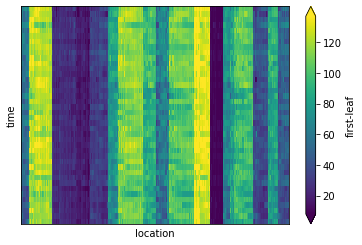

In [24]:
ax = spring_index_sorted.plot.imshow(
    x='location', y='time',
    xticks=[], yticks=[],  # drop tick labels 
    robust=True  # set color bar range from 2nd to 98th percentile
)
cmap = ax.cmap  # will use the same color map in the next plots

Each block of the matrix can be identified as a spatial region whose grid cells have similar first-bloom value over a sub set of years. 

The average spring index value of each co-cluster can be computed via a dedicated utility function in CGC, which return the cluster means in a 2D-array with dimensions `(n_row_clusters, n_col_clusters)`. We calculate the cluster averages and create a `DataArray` for further manipulation and plotting:

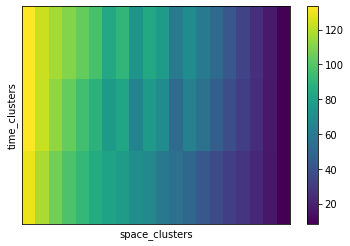

In [25]:
# calculate the co-cluster averages
means = calculate_cocluster_averages(
    spring_index.data, 
    time_clusters, 
    space_clusters, 
    num_time_clusters, 
    num_space_clusters
)
means = xr.DataArray(
    means,
    coords=(
        ('time_clusters', range(num_time_clusters)), 
        ('space_clusters', range(num_space_clusters))
    )
)

# drop co-clusters that are not populated 
means = means.dropna('time_clusters', how='all')
means = means.dropna('space_clusters', how='all')

# use first row- and column-clusters to sort 
space_cluster_order = means.isel(time_clusters=0)
time_cluster_order = means.isel(space_clusters=0)
means_sorted = means.sortby(
    [space_cluster_order, time_cluster_order]
)

# now plot the sorted co-cluster means 
means_sorted.plot.imshow(
    xticks=[], yticks=[],
    cmap=cmap  # use same colorbar
)

We can now visualize the temporal clusters to which each year belongs, and make a histogram of the number of years in each cluster:

(array([ 7., 20., 13.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

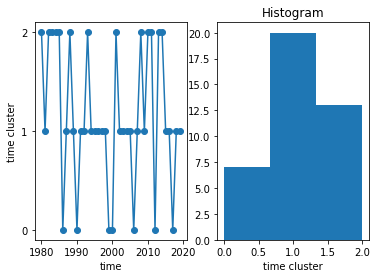

In [26]:
fig, ax = plt.subplots(1, 2)

# line plot
time_clusters.plot(ax=ax[0], x='time', marker='o')
ax[0].set_yticks(range(num_time_clusters))

# temporal cluster histogram
time_clusters.plot.hist(ax=ax[1], bins=num_time_clusters)

Spatial clusters can also be visualized after 'unstacking' the location index that we have initially created, thus reverting to the original (x, y) coordinates:

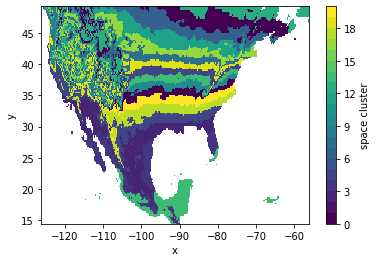

In [27]:
space_clusters_xy = space_clusters.unstack('space')
space_clusters_xy.plot.imshow(
    x='x', y='y', levels=range(num_space_clusters+1)
)

The computed co-cluster means and the spatial clusters can be employed to plot the average first-bloom value for each of the temporal clusters: 

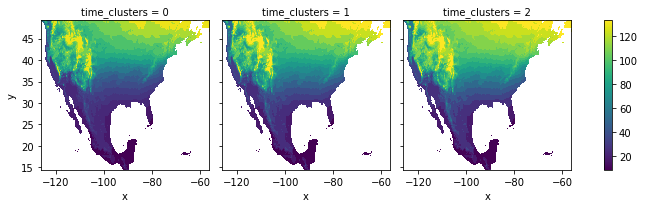

In [28]:
space_means = means.sel(space_clusters=space_clusters)
space_means = space_means.drop_vars(['space_clusters'])
space_means = space_means.unstack('space')
space_means.plot.imshow(
    x='x', y='y', col='time_clusters',
    cmap=cmap  # use same colorbar
)

## K-means refinement

### Overview

We have seen how co-clustering allows one to reorder the rows and columns of a two-dimensional data set such that its elements are sorted in 'blocks'. In this picture, the co-clusters can be identified as the squares in the checkerboard structure. An optional subsequent step consists in performing a standard clustering analysis, such as k-means, to identify similarity patterns across the co-clusters, in such a way that similar squares in the checkerboard can be joined in the same cluster. For the data set considered here, performing such refinement step can be seen as a way to identify sub-regions with similar spring index values across different year spans.

CGC implements this refinement step using [k-means](https://en.wikipedia.org/wiki/K-means_clustering).
The following features are computed for each of the co-clusters and used to perform the refinement clustering analysis:

* mean value;

* standard deviation;

* minimum value;

* maximum value;

* 5% quantile;

* 95% quantile.

The refinement clustering analysis is run for multiple k's, and the optimal value selected as the smallest value for which the sum or centroid variances is below a given threshold. In addition to the information on the previous co-clustering analysis, one needs to specify the range of k values for the search of optimal values when initializing the `Kmeans` object:

In [29]:
km = Kmeans(
    spring_index.data,
    row_clusters=results.row_clusters,
    col_clusters=results.col_clusters,
    n_row_clusters=num_time_clusters,
    n_col_clusters=num_space_clusters,
    k_range=range(1, 11), 
    kmean_max_iter=100,  # max k-means iteration for each k value
    var_thres=5.  # threshold for the sum of centroid variances
)

The refinement analysis is then run as:

In [30]:
results_kmeans = km.compute()

/opt/miniconda3/envs/phenology/lib/python3.7/site-packages/cgc/kmeans.py:181: RuntimeWarning: invalid value encountered in true_divide
  (maximum - minimum)


Visualizing the variance trend as a function of k allows to verify whether the choice of the threshold is properly set (the optimal k value should be approximately equal to [the "elbow" of the curve](https://en.wikipedia.org/wiki/Elbow_method_(clustering))):

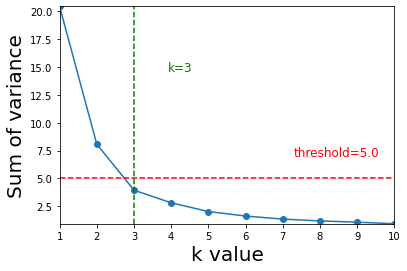

In [31]:
km.plot_elbow_curve()

### Results

The object returned by `Kmeans.compute` contains all results, most importantly the optimal `k` value and the centroids of the co-clusters' means:

In [32]:
print(f"Optimal k value: {results_kmeans.k_value}")
print(f"Centroids of co-clusters' means: {results_kmeans.cl_mean_centroids}")

Optimal k value: 3
Centroids of co-clusters' means: [[ 26.74912445 112.20440998  26.74912445  26.74912445  26.74912445
   69.99499007 112.20440998  69.99499007  69.99499007  69.99499007
   69.99499007 112.20440998 112.20440998  26.74912445  69.99499007
   69.99499007 112.20440998  26.74912445  69.99499007  26.74912445]
 [ 69.99499007 112.20440998  26.74912445  26.74912445  26.74912445
   69.99499007 112.20440998  69.99499007  69.99499007  69.99499007
   69.99499007 112.20440998 112.20440998  26.74912445  69.99499007
   69.99499007 112.20440998  26.74912445  69.99499007  26.74912445]
 [ 69.99499007 112.20440998  26.74912445  26.74912445  26.74912445
   69.99499007 112.20440998 112.20440998  69.99499007  69.99499007
   69.99499007 112.20440998 112.20440998  26.74912445  69.99499007
   69.99499007 112.20440998  26.74912445  69.99499007  69.99499007]]


The centroids can be employed to plot the refined cluster averages of the spring index:

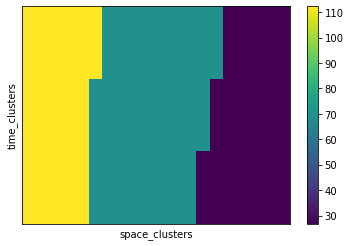

In [33]:
means_kmeans = xr.DataArray(
    results_kmeans.cl_mean_centroids, 
    dims=('time_clusters', 'space_clusters')
)

# drop co-clusters that are not populated  
means_kmeans = means_kmeans.dropna('time_clusters', how='all')
means_kmeans = means_kmeans.dropna('space_clusters', how='all')

# reorder the cluster averages, using the same ordering as for the co-clusters
means_kmeans_sorted = means_kmeans.sortby([
    space_cluster_order, time_cluster_order
])

# finally plot the cluster averages after refinement 
means_kmeans_sorted.plot.imshow(
    xticks=[], yticks=[],
    cmap=cmap
)

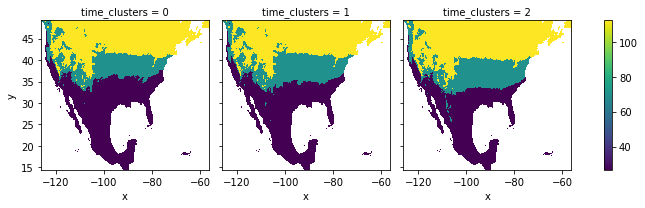

In [34]:
space_means = means_kmeans.sel(space_clusters=space_clusters)
space_means = space_means.unstack('space')
space_means.plot.imshow(
    x='x', y='y', col='time_clusters',
    cmap=cmap
)